In [1]:
%matplotlib inline
# autoreload class definition
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import scipy.io
import os
from seizures.Global import Global

In [2]:
matdict = scipy.io.loadmat(Global.get_subject_folder(os.path.join('Dog_1', 'Dog_1_ictal_segment_1.mat')))
data = matdict['data']

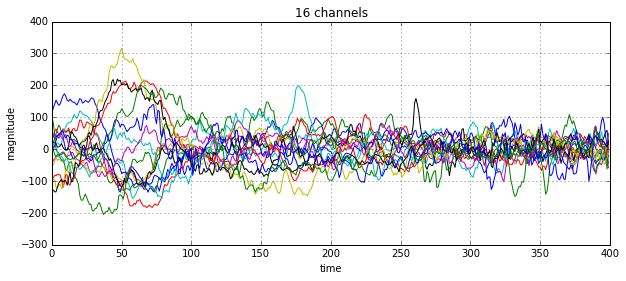

In [3]:
# plot each channel 
plt.figure(figsize=(10,4))
plt.plot(data.T)
plt.xlabel('time')
plt.ylabel('magnitude')
plt.title('%d channels'%data.shape[0])
plt.grid(True)

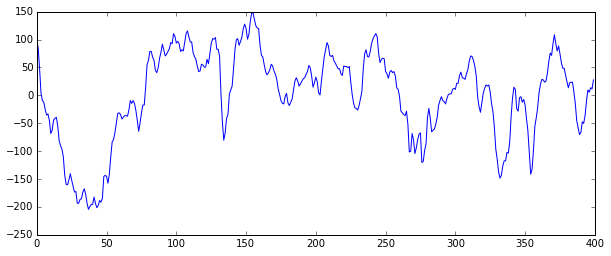

In [4]:
plt.figure(figsize=(10,4))
plt.plot(data[8,:])

In [5]:
np.hstack(data).shape

(6400,)

# test DataLoader_v2

In [6]:

from seizures.data.DataLoader_v2 import DataLoader
from seizures.features.RandomFeatures import RandomFeatures
from seizures.features.ARFeatures import ARFeatures
base_folder = Global.path_map('clips_folder')
#base_folder = '/home/nuke/git/gatsby-hackathon-seizure/wj_data/'
feature_extractor = ARFeatures()
loader = DataLoader(base_folder, feature_extractor)
subject_name = 'Dog_1'

X, type_labels, early_labels = loader.training_data(subject_name, max_segments=20)


Loading train data for Dog_1
Load with extractor = AR
Load with params = {'elec_noise_cutoff': [59.0, 61.0], 'targetrate': 400, 'anti_alias_cutoff': 500.0, 'anti_alias_attenuation': 40, 'anti_alias_width': 30.0, 'elec_noise_width': 3.0, 'elec_noise_attenuation': 60.0}
418 interictal segments for Dog_1
178 ictal segments for Dog_1
subsampling from 596 segments to 20
95.0  percent complete         
done


In [7]:
# 
X.shape

(20, 528)

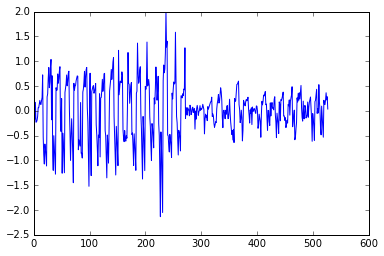

In [8]:
plt.plot(X[2, :])

In [9]:
# load_data() method will fill the content of attribute features_train 
assert(type(loader.features_train)==list)
features_train = loader.features_train
print '#ictal+interictal segments in %s = %d'% (subject_name, len(features_train))
print '#features of %s = %d' % (type(feature_extractor), len(features_train[0]) )
# loader.features_train

#ictal+interictal segments in Dog_1 = 20
#features of <class 'seizures.features.ARFeatures.ARFeatures'> = 528


In [10]:
# data for cross validation
n_fold = 3
max_segments=200
X_list,y_seizure, y_early = loader.blocks_for_Xvalidation(subject_name, n_fold, max_segments)


Loading train data for Dog_1
Load with extractor = AR
Load with params = {'elec_noise_cutoff': [59.0, 61.0], 'targetrate': 400, 'anti_alias_cutoff': 500.0, 'anti_alias_attenuation': 40, 'fs': 400.0, 'anti_alias_width': 30.0, 'elec_noise_width': 3.0, 'elec_noise_attenuation': 60.0}
418 interictal segments for Dog_1
178 ictal segments for Dog_1
subsampling from 596 segments to 200
99.5  percent complete         
done


In [11]:
print len(X_list)
print len(y_seizure)
print len(y_early)
sum(x.shape[0] for x in X_list) 

3
3
3


197

In [12]:
X_list[2].shape
y_early[0]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

## Test gradient boosting classifier

In [13]:

def gen_gaussian_sum(n, d):
    """toy data. X = Gaussian. Y = sum of coordinates of X"""
    X = np.matrix(np.random.randn(n, d))
    y = ( (np.sum(X, 1) + np.random.randn(n, 1)*0.1) > 0.5).astype(np.int)
    #y = np.array(y, dtype=np.int)
    X = np.asarray(X)
    y = np.squeeze(np.asarray(y))
    return X,y

# n x d data matrix
n=100
d=10
X,y = gen_gaussian_sum(n ,d)

print X.shape
print y.shape


(100, 10)
(100,)


In [14]:
from sklearn.ensemble import GradientBoostingClassifier
# fit a gradient boosting classifier
# n_estimators = number of boosting stages
gbc = GradientBoostingClassifier(n_estimators=200)
gbc.verbose=True
gbc.fit(X, y)

      Iter       Train Loss   Remaining Time 
         1           1.2307            0.28s
         2           1.1423            0.25s
         3           1.0538            0.24s
         4           0.9908            0.23s
         5           0.9272            0.23s
         6           0.8716            0.22s
         7           0.8214            0.22s
         8           0.7744            0.22s
         9           0.7315            0.22s
        10           0.6945            0.21s
        20           0.4176            0.18s
        30           0.2542            0.16s
        40           0.1618            0.15s
        50           0.1055            0.14s
        60           0.0725            0.12s
        70           0.0491            0.12s
        80           0.0331            0.11s
        90           0.0237            0.10s
       100           0.0167            0.09s
       200           0.0007            0.00s


GradientBoostingClassifier(init=None, learning_rate=0.1, loss='deviance',
              max_depth=3, max_features=None, max_leaf_nodes=None,
              min_samples_leaf=1, min_samples_split=2, n_estimators=200,
              random_state=None, subsample=1.0, verbose=True,
              warm_start=False)

In [15]:
# testing data
nte = 50
Xte, yte = gen_gaussian_sum(nte, d)

In [16]:
# test the learned gradient boosting classifier
ypred = gbc.predict(Xte)
print 'ground truth: '
print yte
print 'predicted: '
print ypred
print 'accuracy = %f'% ( np.mean(ypred==yte) )

ground truth: 
[1 0 0 1 1 0 1 0 0 0 0 0 1 1 0 1 0 0 0 0 1 0 0 1 0 0 1 0 1 1 0 1 1 0 0 0 1
 0 1 1 0 1 1 0 0 0 1 0 0 0]
predicted: 
[0 0 0 1 0 1 1 0 0 0 0 0 1 1 1 1 1 0 1 0 0 0 0 1 0 0 1 0 1 0 0 1 1 0 0 0 0
 0 1 0 1 1 1 0 0 0 0 0 0 1]
accuracy = 0.740000


In [17]:
# prediction probabilities
ypred_prob = gbc.predict_proba(Xte)

# test my AdaBoostTrees

In [18]:
import seizures.prediction.Boosting
seizures.prediction.Boosting.main()


fitting AdaBoost trees
[ 0.50995996]


# Test scipy stats

In [19]:
import scipy.stats as st
import numpy as np
from seizures.features.StatsFeatures import StatsFeatures

from seizures.data.DataLoader_v2 import DataLoader
from seizures.features.RandomFeatures import RandomFeatures
from seizures.features.ARFeatures import ARFeatures


In [20]:

base_folder = Global.path_map('clips_folder')
feature_extractor = StatsFeatures()
loader = DataLoader(base_folder, feature_extractor)
subject_name = 'Dog_1'

X, type_labels, early_labels = loader.training_data(subject_name, max_segments=10)
X.shape


Loading train data for Dog_1
Load with extractor = Stats
Load with params = {'elec_noise_cutoff': [59.0, 61.0], 'targetrate': 400, 'anti_alias_cutoff': 500.0, 'anti_alias_attenuation': 40, 'anti_alias_width': 30.0, 'elec_noise_width': 3.0, 'elec_noise_attenuation': 60.0}
418 interictal segments for Dog_1
178 ictal segments for Dog_1
subsampling from 596 segments to 10
90.0  percent complete         
done


(10, 48)

## Test plainica

In [ ]:
"""
import scot
import numpy as np
from seizures.data.SubjectEEGData import SubjectEEGData

loader = SubjectEEGData('Patient_1', max_train_segments=10)
L = loader.get_train_data()
tup = L[9]
ins = tup[0]
dndata = ins.eeg_data
nddata = dndata.T

# reducedim: A number of less than 1 in interpreted as 
# the fraction of variance that should remain in the data.
keep = min(nddata.shape[1], 5)
ica = scot.plainica.plainica(nddata, reducedim=keep)
"""

In [ ]:
"""
M = ica.mixing
U = ica.unmixing
# plot mixing matrix

plt.imshow(M)
plt.colorbar()
plt.title('mixing matrix')

# plot unmixing matrix
plt.figure()
plt.imshow(U)
plt.colorbar()
plt.title('unmixing matrix')
"""

# Compare many feature extractors, many predictors on one patient dataset

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.io
import os
from seizures.Global import Global

from seizures.features.ARFeatures import *
from seizures.features.MixFeatures import StackFeatures
from seizures.features.PLVFeatures import PLVFeatures
from seizures.features.XCHUHFeatures import XCHUHFeatures
from seizures.features.SEFeatures import SEFeatures
#from seizures.features.LyapunovFeatures import LyapunovFeatures
from seizures.features.StatsFeatures import StatsFeatures
from seizures.prediction.ForestPredictor import ForestPredictor
from seizures.prediction.Boosting import AdaBoostTrees
from seizures.pipelines.FeaturePredictorTest import CVFeaturesPredictorsTester
from seizures.pipelines.FeaturePredictorTest import CachedCVFeaPredTester


feature_extractors = [
    ARFeatures(), 
    SEFeatures(),
    StatsFeatures(),
    VarLagsARFeatures(4),
    StackFeatures(ARFeatures(), VarLagsARFeatures(4), VarLagsARFeatures(6)),
    StackFeatures(ARFeatures(), VarLagsARFeatures(4)),
    #StackFeatures(ARFeatures(), PLVFeatures(), SEFeatures()),
    #PLVFeatures(),
    #StackFeatures(ARFeatures(), VarLagsARFeatures(5), PLVFeatures()), 
    #StackFeatures(ARFeatures(),  PLVFeatures(), XCHUHFeatures(), SEFeatures())
]
#predictors = [AdaBoostTrees(), ForestPredictor(n_estimators=200)]
predictors = [ ForestPredictor(n_estimators=100, max_features=0.2)]
patient = 'Dog_1'
#patient = 'Patient_1'
#tester = CVFeaturesPredictorsTester(feature_extractors, predictors, patient)

clips_folder = Global.path_map('clips_folder')
#params = {'targetrate': 500};
tester = CachedCVFeaPredTester(
    feature_extractors, predictors, patient, data_path=clips_folder) 
# randomly select subsamples of total segments (ictal + interictal)
# To make it faster. I expect using the full data to give similar result anyway.
max_segments=100

table = tester.test_combination(fold=2, max_segments=max_segments)


418 interictal segments for Dog_1
178 ictal segments for Dog_1
subsampling from 596 segments to 100
99.0  percent complete         
done
Preprocessing params: 
{'elec_noise_cutoff': [59.0, 61.0], 'targetrate': 500, 'anti_alias_cutoff': 500.0, 'anti_alias_attenuation': 40, 'fs': 400, 'anti_alias_width': 30.0, 'elec_noise_width': 3.0, 'elec_noise_attenuation': 60.0}
Evaluating feat: AR + pred: Forest on seizure task
Fitting a random forest predictor
Fitting a random forest predictor
Evaluating feat: AR + pred: Forest on early seizure task
Fitting a random forest predictor
Fitting a random forest predictor
Evaluating feat: SE + pred: Forest on seizure task
Fitting a random forest predictor
Fitting a random forest predictor
Evaluating feat: SE + pred: Forest on early seizure task
Fitting a random forest predictor
Fitting a random forest predictor
Evaluating feat: Stats + pred: Forest on seizure task
Fitting a random forest predictor
Fitting a random forest predictor
Evaluating feat: Stats 

In [3]:
# the argument to print_table(..) can be 
# seizure_mean_auc, seizure_std_auc, early_mean_auc, early_std_auc
table.print_table('seizure_mean_auc')

# From FeaturesPredictsTable
Reporting seizure_mean_auc
+-----------------------------+--------+
|        feat. \ pred.        | Forest |
+-----------------------------+--------+
|              AR             | 0.991  |
|              SE             | 0.988  |
|            Stats            | 0.839  |
|           VLAR(4)           | 0.995  |
| Stack(AR, VLAR(4), VLAR(6)) | 0.994  |
|      Stack(AR, VLAR(4))     | 0.994  |
+-----------------------------+--------+


In [4]:
table.print_table('early_mean_auc')

# From FeaturesPredictsTable
Reporting early_mean_auc
+-----------------------------+--------+
|        feat. \ pred.        | Forest |
+-----------------------------+--------+
|              AR             | 0.935  |
|              SE             |  0.95  |
|            Stats            | 0.687  |
|           VLAR(4)           | 0.894  |
| Stack(AR, VLAR(4), VLAR(6)) | 0.888  |
|      Stack(AR, VLAR(4))     | 0.923  |
+-----------------------------+--------+
